# Recommendations with IBM

In this notebook, an analysis by using real data from the IBM Watson Studio platform was performed with sample codes from Udacity Data Scientist Nani Degree Program. Analysis will cover building a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

import seaborn as sns
from collections import defaultdict

%matplotlib inline

In [2]:
# gather data
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [3]:
# assess data
# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

#### `1.`  Visualize
What is the distribution of how many articles a user interacts with in the dataset?

In [5]:
count_by_email = df.groupby('email')['article_id'].count()
count_by_email

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
                                            ..
ffc6cfa435937ca0df967b44e9178439d04e3537     2
ffc96f8fbb35aac4cb0029332b0fc78e7766bb5d     4
ffe3d0543c9046d35c2ee3724ea9d774dff98a32    32
fff9fc3ec67bd18ed57a34ed1e67410942c4cd81    10
fffb93a166547448a0ff0232558118d59395fecd    13
Name: article_id, Length: 5148, dtype: int64

In [6]:
def hist_box_plot(list_count: pd.Series,
                  x_axis_label: str,
                  y_axis_label: str,
                  bin_incr: int):
    """
    Take the pandas series with counts of each groups and draw a histogram and box plot without removing outliers
    input:
        list_count : pandas Series with group and count
        x_axis_label : string with the x axis name
        y_axis_label: string with the ybaxis name
        bin_incr: integer with incremental bins size for histogram
    output: histogram, box plot 
    """
    
    fig, (ax_box, ax_hist) = plt.subplots(2,
                                        sharex=True,
                                        gridspec_kw={
                                            "height_ratios": (.15, .85)},
                                        figsize=(14, 6))

    sns.boxplot(list_count, ax=ax_box)
    bins = np.arange(0, list_count.max() + bin_incr, bin_incr)
    list_count.hist(grid=False, bins=bins)
    ax_box.set(yticks=[])
    ax_hist.set_ylabel(y_axis_label)
    ax_hist.set_xlabel(x_axis_label)
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)

In [7]:
def get_summary_statistics(list_count: pd.Series, 
                           category_name: str,
                           sort_col_name: str,
                          col_names: list):
    """
    get the summary of the pd.Series and a pd dataframe of the freuquencies number of occurences
    input: list_count - pd.Series with catgeory and counts of sort column,
            category_name - str- catgory column name,
            sort_col_name - str - sort column name,
            col_names - list -column names of the freq summary table
    output: summary_df - series - summary statistics dataframe
            freq_summary - pandas dataframe with number of occurences of each sort column
    """
    summary_df = (list_count
                 .describe())
    freq_summary = (list_count
                    .to_frame()
                    .reset_index()
                    .groupby(category_name)
                    .count()
                    .reset_index()
                    .sort_values(by = sort_col_name, 
                                 ascending = False)
                   )
    freq_summary.columns = col_names
    return summary_df, freq_summary

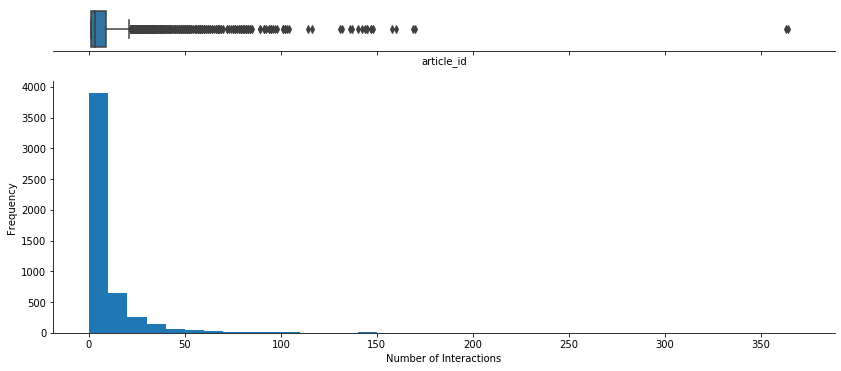

In [8]:
# visual display of the number of times each user interacts with an article.
hist_box_plot(count_by_email, 'Number of Interactions', 'Frequency', 10)

In [9]:
# descriptive statistics of the number of times each user interacts with an article.
summary_df, freq_summary = get_summary_statistics(count_by_email, 
                                                  'article_id', 
                                                  'email', 
                                                  ['interaction_count', 'frequency'])
summary_df

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

In [10]:
# assessing the top number of frequencies
freq_summary

,interaction_count,frequency
0,1,1416
1,2,694
2,3,485
3,4,351
4,5,277
...,...,...
69,70,1
71,73,1
79,81,1
72,74,1


In [11]:
# 50% of individuals interact with 3 number of articles or fewer.
median_val = 3
# The maximum number of user-article interactions by any 1 user is 364.
max_views_by_user = 364

The distribution of the number of user interactions has a positively skewed distribution and majority (1416) users have only interacted with 1 article. There are lots of outliers and one such big outlier is a user who has interacted with 364 articles. Therefore, summary statistics like mean of overall datset would not give a correct picture. In that sence median would be a better statistics and it shows that number of interactions of a user median value is 3

#### `2.` Clean the data
Explore and remove duplicate articles from the **df_content** dataframe.  

In [12]:
# Find and explore duplicate articles
df_content[df_content.duplicated(subset='article_id', keep=False)].sort_values(by='article_id')

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [13]:
# duplicated rows
df_content[df_content.duplicated(subset='article_id')]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [14]:
# Remove any rows that have the same article_id - only keep the first
df_content_unique = df_content.drop_duplicates(subset = ['article_id'], keep = 'first')
# verifying the duplicated rows have been removed and only 5 rows have been removed
df_content_unique[df_content_unique.duplicated(subset='article_id')], df_content_unique.shape, df_content.shape

(Empty DataFrame
 Columns: [doc_body, doc_description, doc_full_name, doc_status, article_id]
 Index: [],
 (1051, 5),
 (1056, 5))

5 duplicated article ids were removed from the content dataframe

#### `3.` Analyze
unique counts

In [15]:
# a. The number of unique articles that have an interaction with a user.
unique_articles = df.article_id.nunique()
# b. The number of unique articles in the dataset (whether they have any interactions or not)
total_articles = df_content_unique.article_id.nunique()
# c. The number of unique users in the dataset. (excluding null values)
unique_users = df.email.nunique()
# d. The number of user-article interactions in the dataset.
user_article_interactions = df.shape[0]

unique_articles, total_articles, unique_users, user_article_interactions

(714, 1051, 5148, 45993)

714 unique aricles have at least one interaction <br>
1051 unique articles are on the IBM platform <br>
5148 unique users are analyzed <br>
45993 user-article interactions exists <br>

`4.` Below cells will analyze the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [16]:
count_by_article_id = (df
                       .groupby('article_id')['email']
                       .count()
                       .to_frame()
                    .reset_index()
#                       columns = ['article_id', 'email_id_count']
                      .sort_values(by='email', ascending = False)
                      )
count_by_article_id.columns = ['article_id', 'email_id_count']
count_by_article_id

,article_id,email_id_count
699,1429.0,937
625,1330.0,927
701,1431.0,671
697,1427.0,643
652,1364.0,627
...,...,...
478,1113.0,1
481,1119.0,1
409,984.0,1
488,1127.0,1


In [17]:
most_viewed_article_id = '1429.0'
max_views = 937

article id 1429.0 was the article with maximum number of views (937)

In [18]:
def email_mapper():
    """map the user email to a user_id column and remove the email column"""
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [19]:
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


In [20]:
articles_interactions = df.title.value_counts().sort_values(ascending=False)
articles_interactions.nlargest(5).index.tolist()

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm']

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

We don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [21]:
def get_top_articles(n, df=df):
    '''
    return the top n article titles with modt interactions
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    article_interact_counts = df.title.value_counts().sort_values(ascending=False)
    top_articles = article_interact_counts.nlargest(n).index.tolist()
    
    return top_articles

def get_top_article_ids(n, df=df):
    '''
    return the top n article ids with modt interactions
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    article_interact_counts = df.article_id.value_counts().sort_values(ascending=False)
    top_articles = article_interact_counts.nlargest(n).index.tolist()
    
 
    return top_articles

In [22]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [23]:
# Returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


Reformatting the **df** dataframe to be shaped with users as the rows and articles as the columns.  

In [24]:
def create_user_item_matrix(df):
    '''
    creating the user-article matrix with 1's and 0's
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = pd.crosstab(df.user_id, columns=[df.article_id])
    user_item[user_item > 0] = 1
    user_item.fillna(0, inplace=True)
    
    return user_item 

user_item = create_user_item_matrix(df)
user_item

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Tests
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [26]:
user_id = 1
similarity_matrix = user_item.dot(np.transpose(user_item))

`2.` Find the most similar users as a list (from most similar to least similar) without containing the provided user_id. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

In [27]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user and remove own users id
    similarity = user_item[user_item.index != user_id].dot(user_item.loc[user_id ])

    # sort by similarity and create list of just the ids from most to least similar
    most_similar_users = similarity.sort_values(ascending=False).index.tolist()

    return most_similar_users
        

In [28]:
# Spot check of the function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 3697]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Find the recommended articles for the users

In [31]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''

    df.article_id = df.article_id.astype(str)
    
    article_names = (df
                     .drop_duplicates('article_id')
                     .set_index('article_id')
                     .loc[article_ids]
                     .title
                     .tolist()
                    )
    
    return article_names


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''


    user = user_item.loc[user_id] 
    article_ids = user[user==1].index.tolist()
    article_ids = [str(i)for i in article_ids]
    
    
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''

    seen_articles  = get_user_articles(user_id)[0]
    users = find_similar_users(user_id)
    
    recs = []
    for user in users:
        rec_articles = get_user_articles(user)[0]

        for article in rec_articles:
            if article not in seen_articles and article not in recs:
                recs.append(article)
                if len(recs) == m:
                    return recs

In [32]:
# Return 10 recommendations for user 1
get_article_names(user_user_recs(1, 10))

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

In [33]:
# Testing the functions
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [34]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) with articleid, title and email
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    neighbors_df = pd.DataFrame()
    
    # compute similarity of each user to the provided user and get them sorted with most similar in top
    similarity = user_item[user_item.index != user_id].dot(user_item.loc[user_id ]).sort_values(ascending=False)
    
    neighbors_df['neighbor_id'] = similarity.index.tolist()
    neighbors_df['similarity'] = similarity.tolist()
    neighbors_df['num_interactions'] = (neighbors_df['neighbor_id']
                                        .apply(lambda x: df[df['user_id'] == x]
                                               .shape[0]))
    neighbors_df = (neighbors_df
                    .sort_values(['similarity', 'num_interactions'], 
                                 ascending=False)) 
    
    return neighbors_df


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
    '''
    
    
    similar_users = list(get_top_sorted_users(user_id)['neighbor_id'].values)
    recs = loop_through_users(user_id, similar_users, m)
    rec_names = get_article_names(recs)  
    
    
    return recs, rec_names

In [35]:
# spot check
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['12.0', '109.0', '125.0', '142.0', '164.0', '205.0', '302.0', '336.0', '362.0', '465.0']

The top 10 recommendations for user 20 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook', 'tensorflow quick tips', 'statistics for hackers', 'neural networks for beginners: popular types and applications', 'learn tensorflow and deep learning together and now!', "a beginner's guide to variational methods", 'accelerate your workflow with dsx', 'challenges in deep learning', 'dsx: hybrid mode', 'introduction to neural networks, advantages and applications']


`5.` Use the functions from above to correctly fill in the solutions to the dictionary below.

In [36]:
get_top_sorted_users(1).head(2)

,neighbor_id,similarity,num_interactions
0,3933,35,45
1,23,17,364


In [37]:
get_top_sorted_users(131).head(10)

,neighbor_id,similarity,num_interactions
0,3870,74,144
1,3782,39,363
2,23,38,364
3,203,33,160
4,4459,33,158
6,98,29,170
8,3764,29,169
5,49,29,147
7,3697,29,145
9,242,25,148


In [38]:
### Tests with a dictionary of results

# Find the user that is most similar to user 1 
user1_most_sim = 3933
# Find the 10th most similar user to user 131
user131_10th_sim = 242 

In [39]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?

Since there is no historical data to provide the recommendations we can use a simple rank based system and recommend the most popular/ most interacted articles.

`7.` Using the existing functions, providing the top 10 recommended articles to be provided for  a new user below. 

In [40]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)# Your recommendations here
new_user_recs


['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [41]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` Loading built matrices

In [42]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [43]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` Using Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [44]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)

Numpy SVD works only when there are no missing values. Here as there are no missing values we can use Singular Value Decomosition in Numpy.

**Provide your response here.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

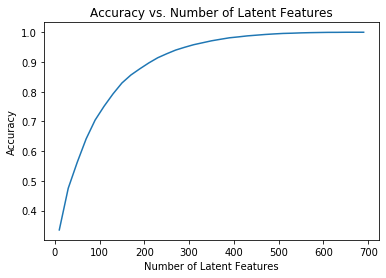

In [45]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [46]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)

    # Find users both in test and in train
    train_idx = set(user_item_train.index)
    test_idx = set(user_item_test.index)
    matching_idx = train_idx.intersection(test_idx)
    
    # Find movies both in test and in train
    train_arts = set(user_item_train.columns)
    test_arts = set(user_item_test.columns)
    matching_cols = train_arts.intersection(test_arts)


    user_item_test = user_item_test.loc[matching_idx, matching_cols]
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [47]:
user_item_train.shape, user_item_test.shape, len(test_idx), len(test_arts)

((4487, 714), (20, 574), 682, 574)

In [49]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}
t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [50]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [ ]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

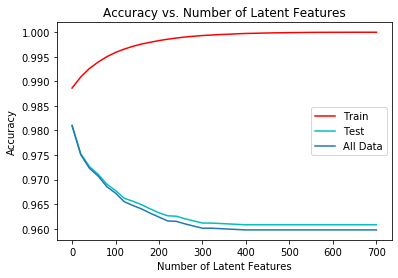

In [53]:
row_idxs = user_item_train.index.isin(test_idx)
col_idxs = user_item_train.columns.isin(test_arts)
u_test = u_train[row_idxs, :]
vt_test = vt_train[:, col_idxs]

num_latent_feats = np.arange(0, 700+10, 20)
sum_errs_train = []
sum_errs_test = []
all_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    all_errs.append(1 - ((np.sum(user_item_test_preds)+np.sum(np.sum(user_item_test)))/(user_item_test.shape[0]*user_item_test.shape[1])))
    
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    diffs_test = np.subtract(user_item_test, user_item_test_preds)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0]*user_item_test.shape[1]), label='Train', color='r');
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(user_item_test.shape[0]*user_item_test.shape[1]), label='Test', color='c');
plt.plot(num_latent_feats, all_errs, label='All Data');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend();

#### `3.` Evaluation

Given the circumstances of the results, discuss what we can  do to determine if the recommendations made with any of the above recommendation systems are an improvement to how users currently find articles? 

**As the number of latent features increases, even though the accuracy of training set increases the accuracy of test set decreases. This might be due to an overfitting situation. Common users among train and test set are very few and the training set we have used doesnot represent the whole population.
Inorder to improve the recommendations we can use techniques like collaborative filtering or content based recommendations. Further with A/B testing we can determine whether the recommendations genertaed are working in practice


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [55]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0